In [82]:
### Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, medfilt

In [83]:
### Load datasets
optical_data = pd.read_csv("distance-sequence-1.csv")
servo_data = pd.read_csv("distance-sequence-servo-output-1.csv")
print(optical_data)

       Item1.Item1.X  Item1.Item1.Y  Item1.Item1.Brightness  Item1.Item2  \
0                  0              0                      93  2098.740032   
1                  0              0                      90  2098.750016   
2                  0              0                      91  2098.760032   
3                  0              0                      89  2098.770016   
4                  0              0                      91  2098.780032   
...              ...            ...                     ...          ...   
51045              0              0                     109  2609.190016   
51046              0              0                     100  2609.200032   
51047              0              0                     105  2609.210016   
51048              0              0                     103  2609.220032   
51049              0              0                     104  2609.230016   

             Item2  
0      3677.573984  
1      3677.584000  
2      3677.593984  
3  

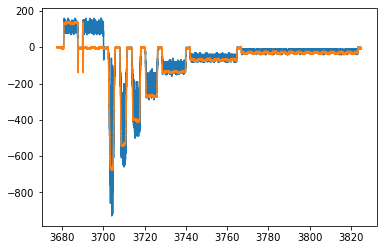

In [113]:
### Preview visualisation
time_range = (3500, 3825)

optical_motion = optical_data["Item1.Item1.X"]
optical_timebase = optical_data["Item2"]
servo_motion = servo_data["Item1"] - servo_data["Item1"][0] # Normalize to servo analog offset
servo_timebase = servo_data["Item2"]

optical_preview_index = np.where((optical_timebase >= time_range[0]) & (optical_timebase <= time_range[1]))[0]
servo_preview_index = np.where((servo_timebase >= time_range[0]) & (servo_timebase <= time_range[1]))[0]

plt.figure()
plt.plot(optical_timebase[optical_preview_index], optical_motion[optical_preview_index] * 10)
plt.plot(servo_timebase[servo_preview_index], -servo_motion[servo_preview_index])

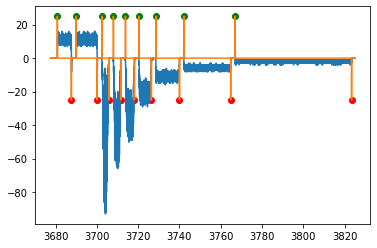

In [114]:
### Extract trial epochs
optical_diff = np.diff(optical_motion)

# Signal envelope
filtered_optical = filtered = np.abs(medfilt(optical_motion, 101))
filtered_optical[filtered_optical < 2] = 0
filtered_optical[filtered_optical > 0] = 25
on_signal = np.diff(filtered)
on_times = find_peaks(on_signal, height=1)[0]
off_times = find_peaks(-on_signal, height=1)[0]

# Plot preview trial extraction
plt.figure()
plt.plot(optical_timebase[optical_preview_index], optical_motion[optical_preview_index])
plt.plot(optical_timebase[optical_preview_index], on_signal[optical_preview_index])

preview_on_times = on_times[(on_times >= optical_preview_index[0]) & (on_times <= optical_preview_index[-1])]
preview_off_times = off_times[(off_times >= optical_preview_index[0]) & (off_times <= optical_preview_index[-1])]

plt.scatter(optical_timebase[preview_on_times], np.ones(len(optical_timebase[preview_on_times])) * 25, c='g')
plt.scatter(optical_timebase[preview_off_times], np.ones(len(optical_timebase[preview_off_times])) * -25, c='r')

In [115]:
### Organise by trial, 0 represents homing trials
# trial types for 1 experiment
distances = np.array([0, 0, 400, 400, 400, 400, 400, 400, 400, 200, 200, 200, 200, 200, 200, 200, 100, 100, 100, 100, 100, 100, 100, -400, -400, -400, -400, -400, -400, -400, -200, -200, -200, -200, -200, -200, -200, -100, -100, -100, -100, -100, -100, -100])
velocities = np.array([0, 0, 250, 200, 150, 100, 50,  25,  10,  250, 200, 150, 100, 50,  25,  10,  250, 200, 150, 100, 50,  25,  10, 250, 200, 150, 100, 50,  25,  10,  250, 200, 150, 100, 50,  25,  10,  250, 200, 150, 100, 50,  25,  10 ])

# Exclude homing trials
homing_on_times = on_times[velocities == 0]
homing_off_times = off_times[velocities == 0]

trial_on_times = on_times[velocities > 0]
trial_off_times = off_times[velocities > 0]
distances = distances[velocities > 0]
velocities = velocities[velocities > 0]

# check trial matching
assert len(trial_on_times) == len(trial_off_times), "Mismatch trial times"
assert len(trial_on_times) == len(distances) == len(velocities), "Mismatch trial number"

0.0085156391249322


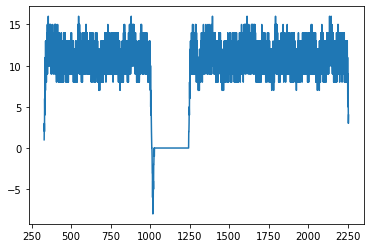

In [182]:
### Estimate true distance from homing trials
homing_distance_cm = 94.2

plt.figure()
plt.plot(optical_motion[homing_on_times[0]:homing_off_times[-1]])

homing_distance_integral = list()
for index in range(len(homing_on_times)):
    signal_period = np.array(optical_motion[homing_on_times[index]:homing_off_times[index]])
    homing_distance_integral.append(np.sum(signal_period))

distance_coeff = homing_distance_cm / homing_distance_integral[1]
print(distance_coeff)

Text(0, 0.5, 'Optical distance (cm)')

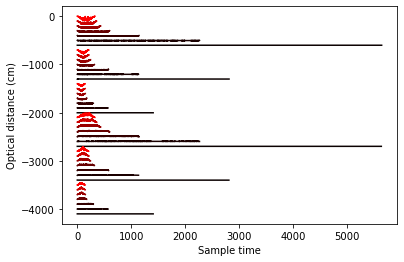

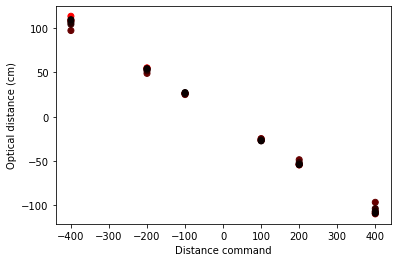

In [183]:
### Stats for each trial + sanity check plot
distance_integral = list()
cmap = list(map(lambda v: (v / np.max(velocities), 0, 0), velocities))

plt.figure()
for t_index in range(len(trial_on_times)):
    signal_period = np.array(optical_motion[trial_on_times[t_index]:trial_off_times[t_index]])
    distance_integral.append(np.sum(signal_period) * distance_coeff)
    plt.plot(signal_period + (t_index*-100), c=cmap[t_index])
plt.xlabel("Sample time")
plt.ylabel("Optical distance (cm)")

distance_integral = np.array(distance_integral)

plt.figure()
plt.scatter(distances, distance_integral, c=cmap)
plt.xlabel("Distance command")
plt.ylabel("Optical distance (cm)")

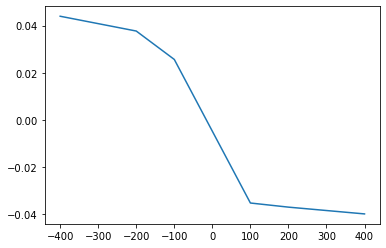

In [184]:
### Position error across all trials
mean_at_d = list()
std_at_d = list()
pos_error = list()
for d in np.unique(distances):
    mean_at_d.append(np.mean(distance_integral[distances == d]))
    std_at_d.append(np.std(distance_integral[distances == d]))
    pos_error.append(np.std(distance_integral[distances == d]) / np.mean(distance_integral[distances == d]))
    # print(d, mean_at_d, std_at_d, std_at_d / mean_at_d)

plt.figure()
plt.plot(np.unique(distances), pos_error)

-0.01299200000039491
-0.012000000000170985
0.028000000000247383
0.027008000000023458
0.03702399999974659
0.009984000000258675
0.029023999999935768
0.006015999999817723
0.007008000000041648
-0.00899200000003475
0.012991999999940163
0.019007999999757885
0.03900800000019444
0.015007999999852473
0.0
-0.007008000000041648
-0.0039999999999054126
-0.018015999999988708
0.005984000000353262
0.030015999999704945
0.027999999999792635
-0.01702400000021953
-0.00601600000027247
0.010015999999723135
0.0
-0.0019839999999931024
0.016991999999845575
0.007999999999810825
-0.0179840000000695
-0.020991999999750988
-0.020991999999750988
-0.03900800000019444
0.019008000000212633
0.0039999999999054126
0.01897599999938393
0.007999999999810825
-0.04102400000010675
-0.017023999999764783
0.0070079999995869
-0.01599999999962165
0.028000000000247383
0.02400000000034197


(array([1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 2., 4., 1., 0., 2., 0., 1.,
        2., 1., 1., 2., 0., 1., 2., 4., 2., 1., 0., 2., 1., 2., 0., 1., 0.,
        4., 2., 0., 0., 0., 2.]),
 array([-0.041024 , -0.0390232, -0.0370224, -0.0350216, -0.0330208,
        -0.03102  , -0.0290192, -0.0270184, -0.0250176, -0.0230168,
        -0.021016 , -0.0190152, -0.0170144, -0.0150136, -0.0130128,
        -0.011012 , -0.0090112, -0.0070104, -0.0050096, -0.0030088,
        -0.001008 ,  0.0009928,  0.0029936,  0.0049944,  0.0069952,
         0.008996 ,  0.0109968,  0.0129976,  0.0149984,  0.0169992,
         0.019    ,  0.0210008,  0.0230016,  0.0250024,  0.0270032,
         0.029004 ,  0.0310048,  0.0330056,  0.0350064,  0.0370072,
         0.039008 ]),
 <BarContainer object of 40 artists>)

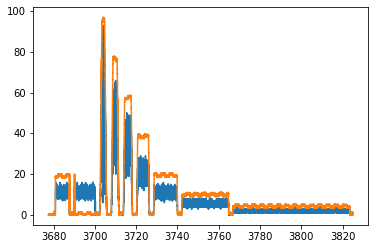

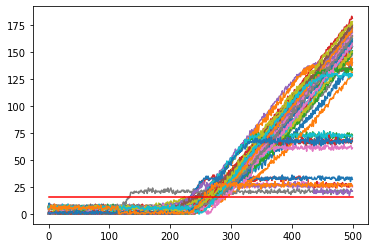

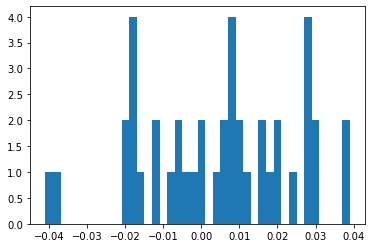

In [179]:
### Latencies between optical measurement and servo feedback
plt.figure()
plt.plot(optical_timebase[optical_preview_index], np.abs(optical_motion[optical_preview_index]))
plt.plot(servo_timebase[servo_preview_index], np.abs(servo_motion[servo_preview_index]) / 7)

# get baselines for optical and servo recordings
# optical_baseline = np.mean(optical_motion[np.abs(optical_motion) < 3]) + np.std(optical_motion[np.abs(optical_motion) < 3]) * 3
optical_baseline = 0
servo_baseline = np.mean(servo_motion[np.abs(servo_motion) < 10]) + np.std(servo_motion[np.abs(servo_motion) < 10]) * 4

# get ramps for optical and servo trial starts
optical_start_times = optical_timebase[trial_on_times] - 0.3

time_diffs = list()

plt.figure()
window = 500
for t in optical_start_times:
    os = np.where(optical_timebase >= t)[0][0] # what time did this optical event start?
    os_t = optical_timebase[os]
    ss = np.where(servo_timebase >= t)[0][0] # what time did the matching servo event start?
    ss_t = servo_timebase[ss]

    # what was the first time that this optical event exceeded baseline?
    optical_rise_time = np.array(optical_timebase[(optical_timebase > os_t) & (np.abs(optical_motion) > optical_baseline)])[0] - os_t

    # what was the first time that this servo event exceeded baseline?
    servo_rise_time = np.array(servo_timebase[(servo_timebase > ss_t) & (np.abs(servo_motion) > servo_baseline)])[0] - ss_t

    time_diffs.append(optical_rise_time - servo_rise_time)
    print((optical_rise_time - servo_rise_time))

    optical_rise = np.array(np.abs(optical_motion[os:(os+window)]))
    servo_rise = np.array(np.abs(servo_motion[ss:(ss+window)]))

    plt.plot(servo_rise)

plt.plot([0, window], [servo_baseline, servo_baseline], 'r')

plt.figure()
plt.hist(np.array(time_diffs), 40)